In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
n_features = 5
classes = 5
cuts = 5
data = pd.read_csv(f'./data_{n_features}_{cuts}_cuts.csv')
display(data.head(5))

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,ClassId,Path
0,5162.50,2572.0,5234.50,2732.0,5423.50,2787.0,5708.75,2707.0,6015.75,2759.0,...,3691.75,2725.0,3344.50,2885.0,3163.50,2880.0,3183.50,2774.0,0,Train/0/00000_00000_00000.png
1,5233.75,2842.0,5369.25,2887.0,5538.00,2914.0,5683.25,2881.0,5831.50,2791.0,...,3910.50,2539.0,3490.00,2686.0,3177.25,2791.0,3108.25,2815.0,0,Train/0/00000_00000_00001.png
2,5389.00,2793.0,5589.25,2908.0,5825.75,2905.0,5750.50,2752.0,4823.25,2634.0,...,3952.25,2507.0,3656.25,2590.0,3287.25,2661.0,3061.50,2688.0,0,Train/0/00000_00000_00002.png
3,5556.25,2800.0,5831.00,2848.0,5861.50,2832.0,5173.00,2713.0,3629.00,2546.0,...,3814.50,2545.0,3387.75,2595.0,3038.50,2643.0,2935.00,2646.0,0,Train/0/00000_00000_00003.png
4,5076.25,2856.0,5329.00,2860.0,5617.75,2854.0,5901.25,2912.0,6081.25,3044.0,...,3550.75,2680.0,3831.00,2662.0,3957.25,2707.0,3784.50,2775.0,0,Train/0/00000_00000_00004.png


In [3]:
X = data.iloc[:,:-2]
y = data.iloc[:,-2:-1]
display(X.head(5))
display(y.head(5))

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
0,5162.50,2572.0,5234.50,2732.0,5423.50,2787.0,5708.75,2707.0,6015.75,2759.0,...,3937.75,2495.0,3691.75,2725.0,3344.50,2885.0,3163.50,2880.0,3183.50,2774.0
1,5233.75,2842.0,5369.25,2887.0,5538.00,2914.0,5683.25,2881.0,5831.50,2791.0,...,3986.75,2453.0,3910.50,2539.0,3490.00,2686.0,3177.25,2791.0,3108.25,2815.0
2,5389.00,2793.0,5589.25,2908.0,5825.75,2905.0,5750.50,2752.0,4823.25,2634.0,...,3897.00,2481.0,3952.25,2507.0,3656.25,2590.0,3287.25,2661.0,3061.50,2688.0
3,5556.25,2800.0,5831.00,2848.0,5861.50,2832.0,5173.00,2713.0,3629.00,2546.0,...,4001.75,2556.0,3814.50,2545.0,3387.75,2595.0,3038.50,2643.0,2935.00,2646.0
4,5076.25,2856.0,5329.00,2860.0,5617.75,2854.0,5901.25,2912.0,6081.25,3044.0,...,3488.00,2719.0,3550.75,2680.0,3831.00,2662.0,3957.25,2707.0,3784.50,2775.0


,ClassId
0,0
1,0
2,0
3,0
4,0


In [4]:
X = (X-X.mean())/X.std()
display(X.head(5))

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
0,1.131742,-0.028802,1.189054,0.050042,1.309473,0.083976,1.472732,0.059054,1.642823,0.091098,...,1.036974,0.217407,0.872491,0.348444,0.650241,0.440949,0.527198,0.442769,0.531000,0.388317
1,1.165560,0.091344,1.253425,0.119377,1.364648,0.141109,1.460344,0.137841,1.552301,0.105652,...,1.067160,0.194757,1.003893,0.247282,0.736259,0.332140,0.535274,0.393817,0.486967,0.410955
2,1.239247,0.069539,1.358520,0.128771,1.503308,0.137061,1.493013,0.079430,1.056944,0.034246,...,1.011871,0.209857,1.028971,0.229878,0.834544,0.279649,0.599883,0.322313,0.459611,0.340834
3,1.318630,0.072654,1.474005,0.101932,1.520535,0.104220,1.212473,0.061771,0.470204,-0.005778,...,1.076400,0.250303,0.946226,0.250545,0.675810,0.282383,0.453779,0.312413,0.385588,0.317645
4,1.090805,0.097574,1.234197,0.107299,1.403078,0.114117,1.566245,0.151878,1.675004,0.220721,...,0.759916,0.338207,0.787794,0.323969,0.937855,0.319017,0.993408,0.347615,0.882683,0.388869


In [5]:
for i in range(classes):
    d0 = data[data['ClassId'] == i]
    print(d0.shape)

(195, 82)
(2158, 82)
(2466, 82)
(1599, 82)
(2239, 82)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
for i in range(classes):
    d0 = y_test[y_test['ClassId'] == i]
    print(d0.shape)

(54, 1)
(669, 1)
(746, 1)
(470, 1)
(659, 1)


In [8]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
svm = LinearSVC(dual=False)

In [10]:
svm.fit(X_train, y_train.values.ravel())

LinearSVC(dual=False)

In [11]:
predict = svm.predict(X_test)

In [12]:
display(svm.feature_names_in_)
display(svm.classes_)

array(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8',
       'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24',
       'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32',
       'f_33', 'f_34', 'f_35', 'f_36', 'f_37', 'f_38', 'f_39', 'f_40',
       'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46', 'f_47', 'f_48',
       'f_49', 'f_50', 'f_51', 'f_52', 'f_53', 'f_54', 'f_55', 'f_56',
       'f_57', 'f_58', 'f_59', 'f_60', 'f_61', 'f_62', 'f_63', 'f_64',
       'f_65', 'f_66', 'f_67', 'f_68', 'f_69', 'f_70', 'f_71', 'f_72',
       'f_73', 'f_74', 'f_75', 'f_76', 'f_77', 'f_78', 'f_79'],
      dtype=object)

array([0, 1, 2, 3, 4], dtype=int64)

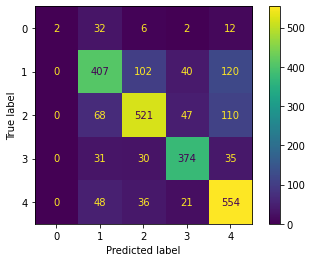

In [13]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()

In [14]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        54
           1       0.69      0.61      0.65       669
           2       0.75      0.70      0.72       746
           3       0.77      0.80      0.78       470
           4       0.67      0.84      0.74       659

    accuracy                           0.72      2598
   macro avg       0.78      0.60      0.59      2598
weighted avg       0.72      0.72      0.71      2598

